In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import xgboost as xgb

In [61]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [62]:
data = pd.read_csv("./../Data/data.csv")
data.head()

,RHA_Year,Agricultural_use,Aquacultural_use,Availability,DBO5_contaminated,Domestic_use,DQO_contaminated,Industrial_use,Livestock_use,Multiple_use,PIB,Population_density,Public_urban_use,Rainfall,Runoff,Services_use,SST_contaminated,Temperature,Water_stress
0,Península de Baja California_2005,5248.11,2.99,4423,13.0,1.76,53.3,143.64,13.37,483.70,4.165,21.751774,654.58,158.00,3012,25.05,4.8,21.023144,86.33
1,Noroeste_2005,11153.63,3.10,8213,21.4,1.14,50.0,98.07,52.36,327.55,2.775,12.699902,1928.18,380.50,5459,5.09,20.0,20.682030,80.45
2,Pacífico Norte_2005,18537.51,627.82,25075,4.9,0.65,33.3,110.91,12.49,153.81,3.045,25.738729,1100.89,646.75,22395,9.64,4.8,21.956878,41.24
3,Balsas_2005,11734.63,419.44,28336,28.5,19.61,47.5,434.13,6.29,296.83,11.950,88.621596,1687.48,855.40,24944,73.05,9.3,18.953706,36.96
4,Pacífico Sur_2005,1900.88,0.80,32226,0.0,1.17,0.0,19.59,0.81,64.01,1.825,48.805376,540.63,1363.00,30800,11.46,0.0,25.115556,3.93


In [63]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 195 entries, 0 to 194
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   RHA_Year            195 non-null    object 
 1   Agricultural_use    195 non-null    float64
 2   Aquacultural_use    195 non-null    float64
 3   Availability        195 non-null    int64  
 4   DBO5_contaminated   195 non-null    float64
 5   Domestic_use        195 non-null    float64
 6   DQO_contaminated    195 non-null    float64
 7   Industrial_use      195 non-null    float64
 8   Livestock_use       195 non-null    float64
 9   Multiple_use        195 non-null    float64
 10  PIB                 195 non-null    float64
 11  Population_density  195 non-null    float64
 12  Public_urban_use    195 non-null    float64
 13  Rainfall            195 non-null    float64
 14  Runoff              195 non-null    int64  
 15  Services_use        195 non-null    float64
 16  SST_cont

In [64]:
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [65]:
X_train = train_data.drop(columns=["RHA_Year", "Water_stress"], axis=1)
y_train = train_data["Water_stress"]

## EDA

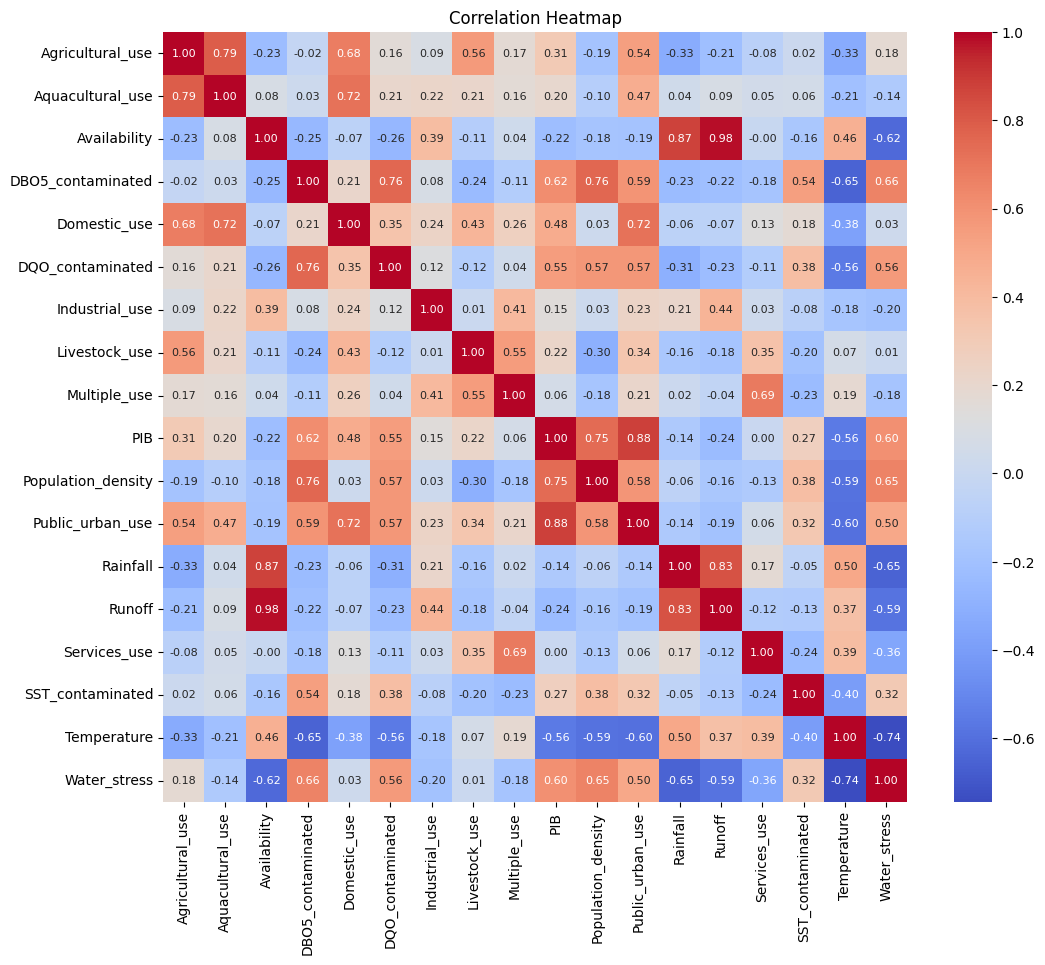

In [66]:
plt.figure(figsize=(12, 10))
correlation_matrix = train_data.corr(numeric_only=True)
sns.heatmap(
    correlation_matrix, annot=True, cmap="coolwarm", annot_kws={"size": 8}, fmt=".2f"
)
plt.title("Correlation Heatmap")
plt.show()

In [67]:
for column in X_train.columns:
    if column != "RHA_Year":
        fig = px.histogram(train_data, x=column, title=f"Histogram of {column}")
        fig.show()

In [68]:
lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X_train, y_train)
lasso_coef = pd.Series(lasso.coef_, index=X_train.columns).sort_values(ascending=False)
print(f"LASSO Coefficients:\n{lasso_coef}")

LASSO Coefficients:
Population_density    0.044472
Public_urban_use      0.006099
Availability          0.000252
Agricultural_use     -0.000000
Livestock_use         0.000000
SST_contaminated      0.000000
PIB                   0.000000
Multiple_use         -0.000000
Industrial_use       -0.000000
DQO_contaminated      0.000000
Domestic_use         -0.000000
DBO5_contaminated     0.000000
Temperature          -0.000000
Runoff               -0.000554
Aquacultural_use     -0.005790
Rainfall             -0.023665
Services_use         -0.032200
dtype: float64


In [69]:
tree_model = ExtraTreesRegressor(n_estimators=100, random_state=42)
tree_model.fit(X_train, y_train)
importances = pd.Series(
    tree_model.feature_importances_, index=X_train.columns
).sort_values(ascending=False)
print(f"Feature Importances (Tree-based Model):\n{importances}")

Feature Importances (Tree-based Model):
Population_density    0.313941
Rainfall              0.158456
Availability          0.149269
PIB                   0.074852
Runoff                0.069983
Agricultural_use      0.048242
Temperature           0.043630
Aquacultural_use      0.032872
Services_use          0.026576
Domestic_use          0.019906
Public_urban_use      0.015482
Multiple_use          0.012664
DQO_contaminated      0.011667
DBO5_contaminated     0.010489
Livestock_use         0.005835
Industrial_use        0.005694
SST_contaminated      0.000442
dtype: float64


### Selection
* Water_stress_lagged
* Population_density
* Public_urban_use
* Availability
* Agricultural_use
* Services_use

In [70]:
selected_features = [
    "Population_density",
    "Public_urban_use",
    "Availability",
    "Agricultural_use",
    "Services_use",
]
target_column = "Water_stress"

In [71]:
train_data_selected = train_data[selected_features + [target_column]]
val_data_selected = val_data[selected_features + [target_column]]
test_data_selected = test_data[selected_features + [target_column]]

In [72]:
X_train = train_data_selected.drop(target_column, axis=1)
y_train = train_data_selected[target_column]
X_val = val_data_selected.drop(target_column, axis=1)
y_val = val_data_selected[target_column]
X_test = test_data_selected.drop(target_column, axis=1)
y_test = test_data_selected[target_column]

In [73]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [74]:
# XGBoost model
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100)
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [75]:
# Random Forest model
rf_model = RandomForestRegressor(n_estimators=100)
rf_model.fit(X_train_scaled, y_train)

RandomForestRegressor()

In [76]:
# Neural Network
class NeuralNet(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.l1 = nn.Linear(input_size, 64)
        self.l2 = nn.Dropout(p=0.1)
        self.l3 = nn.Linear(64, 1)

    def forward(self, x):
        out = F.relu(self.l1(x))
        out = self.l2(out)
        out = self.l3(out)

        return out

In [77]:
input_size = X_train_scaled.shape[1]
neural_net = NeuralNet(input_size).to(device)
print(neural_net)

NeuralNet(
  (l1): Linear(in_features=5, out_features=64, bias=True)
  (l2): Dropout(p=0.1, inplace=False)
  (l3): Linear(in_features=64, out_features=1, bias=True)
)


In [78]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(neural_net.parameters(), lr=0.001)

In [79]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values.reshape(-1, 1), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values.reshape(-1, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values.reshape(-1, 1), dtype=torch.float32)

In [80]:
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
dev_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, drop_last=True)
dev_dataloader = DataLoader(dev_dataset, batch_size=len(dev_dataset), shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=True)

In [81]:
train_losses = []
val_losses = []

for epoch in range(10000):
    neural_net.train()
    train_loss = 0.0

    for X_batch, y_batch in train_dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = neural_net(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_batch.size(0)

    neural_net.eval()
    with torch.no_grad():
        X_val_tensor_gpu, y_val_tensor_gpu = X_val_tensor.to(device), y_val_tensor.to(
            device
        )
        val_outputs = neural_net(X_val_tensor_gpu)
        val_loss = criterion(val_outputs, y_val_tensor_gpu)

    train_loss = train_loss / len(train_dataset)
    val_loss = val_loss.item()

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    if epoch == 0 or (epoch + 1) % 10 ** np.floor(np.log10(epoch + 1)) == 0:
        print(
            f"Epoch {epoch+1}, Train MSE: {train_loss:.4f}, Validation MSE: {val_loss:.4f}"
        )

Epoch 1, Train MSE: 3448.1760, Validation MSE: 4408.2334
Epoch 2, Train MSE: 3589.5687, Validation MSE: 4362.5957
Epoch 3, Train MSE: 3530.4004, Validation MSE: 4315.7671
Epoch 4, Train MSE: 3554.6405, Validation MSE: 4260.4902
Epoch 5, Train MSE: 3435.8080, Validation MSE: 4198.3633
Epoch 6, Train MSE: 3339.7158, Validation MSE: 4131.4595
Epoch 7, Train MSE: 3352.1555, Validation MSE: 4046.6497
Epoch 8, Train MSE: 3267.8704, Validation MSE: 3949.0967
Epoch 9, Train MSE: 2975.9204, Validation MSE: 3844.5708
Epoch 10, Train MSE: 3115.4437, Validation MSE: 3717.2649
Epoch 20, Train MSE: 1660.5505, Validation MSE: 2042.6688
Epoch 30, Train MSE: 638.7479, Validation MSE: 746.1724
Epoch 40, Train MSE: 317.2903, Validation MSE: 305.9951
Epoch 50, Train MSE: 211.1327, Validation MSE: 190.5564
Epoch 60, Train MSE: 168.3946, Validation MSE: 155.6868
Epoch 70, Train MSE: 166.7918, Validation MSE: 138.6820
Epoch 80, Train MSE: 154.9747, Validation MSE: 127.5808
Epoch 90, Train MSE: 126.7475, Vali

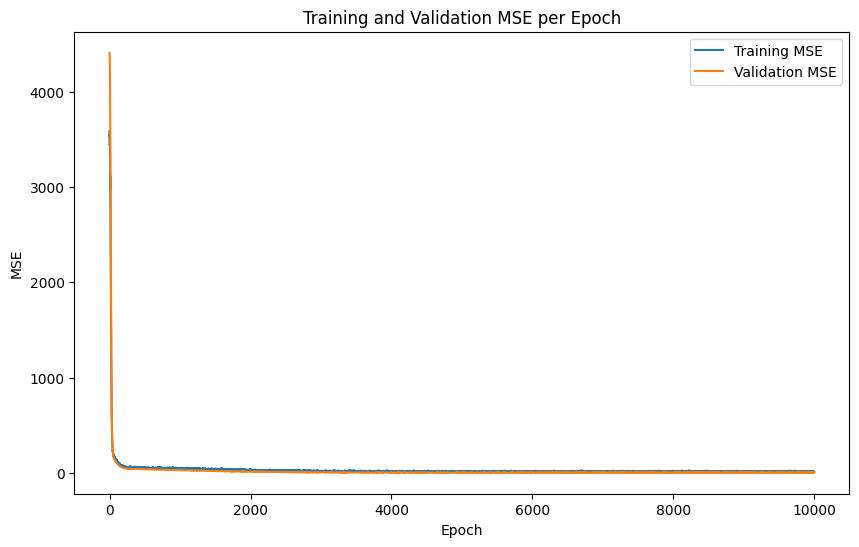

In [82]:
# Plotting training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training MSE")
plt.plot(val_losses, label="Validation MSE")
plt.title("Training and Validation MSE per Epoch")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [83]:
def predict(model, X):
    model.eval()
    with torch.no_grad():
        inputs = torch.tensor(X, dtype=torch.float32)
        outputs = model(inputs).numpy().squeeze()
    return outputs

In [84]:
def permutation_importance(model, X, y, metric=r2_score, scaler=None):
    # Baseline performance
    if scaler:
        X_scaled = scaler.transform(X)
    else:
        X_scaled = X

    baseline_performance = metric(y, predict(model, X_scaled))
    importances = {}

    for i, column in enumerate(X.columns):
        # Permute the column
        X_permuted = X_scaled.copy()
        X_permuted[:, i] = np.random.permutation(X_permuted[:, i])

        # Measure performance with the permuted data
        permuted_performance = metric(y, predict(model, X_permuted))
        importances[column] = baseline_performance - permuted_performance

    return importances

In [85]:
# If X_val is a pandas DataFrame, convert it to numpy array right before transformation
X_val_array = X_val.to_numpy() if isinstance(X_val, pd.DataFrame) else X_val
y_val_array = y_val.to_numpy() if isinstance(y_val, pd.Series) else y_val

# Calculate importances
importances = permutation_importance(neural_net, X_val, y_val_array, scaler=scaler)
print(importances)

{'Population_density': 0.09908921199925325, 'Public_urban_use': 0.08806817175803416, 'Availability': 1.2247202021816808, 'Agricultural_use': 0.38396200584061524, 'Services_use': 0.003049681455284059}


In [86]:
def evaluate_model(model, X, y, model_type="sklearn"):
    if model_type == "sklearn":
        y_pred = model.predict(X)
    elif model_type == "torch":
        with torch.no_grad():
            y_pred = model(torch.tensor(X, dtype=torch.float32)).squeeze().numpy()
    mse = mean_squared_error(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    return mse, mae, rmse, r2

In [87]:
# Evaluating XGBoost on Validation Data
mse_xgb, mae_xgb, rmse_xgb, r2_xgb = evaluate_model(xgb_model, X_val_scaled, y_val)
# Evaluating XGBoost on Test Data
mse_xgb_test, mae_xgb_test, rmse_xgb_test, r2_xgb_test = evaluate_model(
    xgb_model, X_test_scaled, y_test
)

# Evaluating Random Forest on Validation Data
mse_rf, mae_rf, rmse_rf, r2_rf = evaluate_model(rf_model, X_val_scaled, y_val)
# Evaluating Random Forest on Test Data
mse_rf_test, mae_rf_test, rmse_rf_test, r2_rf_test = evaluate_model(
    rf_model, X_test_scaled, y_test
)

# Evaluating Neural Network
mse_nn, mae_nn, rmse_nn, r2_nn = evaluate_model(
    neural_net, X_val_scaled, y_val, model_type="torch"
)
# Evaluating Neural Network on Test Data
mse_nn_test, mae_nn_test, rmse_nn_test, r2_nn_test = evaluate_model(
    neural_net, X_test_scaled, y_test, model_type="torch"
)

In [88]:
# Metrics names
metrics = ["MSE", "MAE", "RMSE", "R2"]

# Storing validation results in a dictionary
validation_results = {
    "XGBoost": [mse_xgb, mae_xgb, rmse_xgb, r2_xgb],
    "Random Forest": [mse_rf, mae_rf, rmse_rf, r2_rf],
    "Neural Network": [mse_nn, mae_nn, rmse_nn, r2_nn],
}

# Storing test results in a dictionary
test_results = {
    "XGBoost": [mse_xgb_test, mae_xgb_test, rmse_xgb_test, r2_xgb_test],
    "Random Forest": [mse_rf_test, mae_rf_test, rmse_rf_test, r2_rf_test],
    "Neural Network": [mse_nn_test, mae_nn_test, rmse_nn_test, r2_nn_test],
}

# Creating DataFrames from the results
validation_results_df = pd.DataFrame(validation_results, index=metrics)
test_results_df = pd.DataFrame(test_results, index=metrics)

# Displaying the DataFrames
print("Validation Results:")
print(validation_results_df)
print("\nTest Results:")
print(test_results_df)

Validation Results:
         XGBoost  Random Forest  Neural Network
MSE   186.881716       2.203357        5.380340
MAE     3.800741       0.814111        1.577377
RMSE   13.670469       1.484371        2.319556
R2      0.898943       0.998809        0.997091

Test Results:
       XGBoost  Random Forest  Neural Network
MSE   0.725975       2.495507        3.350579
MAE   0.526667       0.728600        1.219617
RMSE  0.852042       1.579717        1.830459
R2    0.998724       0.995613        0.994110
